In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn as nn

import nibabel as nib
import os
import time
import gc
import copy

import albumentations as A
from albumentations.pytorch import ToTensorV2


/home/bdbotond/anaconda3/lib/python3.12/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:

class MedicalImageDataset(Dataset):
    def __init__(self, images_dir, masks_dir, target_size=(128, 128, 32), transform=None, num_classes=2):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.target_size = target_size
        self.num_classes = num_classes
        self.image_files = sorted([f for f in os.listdir(images_dir) if f.endswith('.nii.gz')])
        self.mask_files = sorted([f for f in os.listdir(masks_dir) if f.endswith('.nii.gz')])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = os.path.join(self.images_dir, self.image_files[idx])
        mask_path = os.path.join(self.masks_dir, self.mask_files[idx])

        # Load the image and mask
        image = nib.load(image_path).get_fdata()
        mask = nib.load(mask_path).get_fdata()

        # Convert to PyTorch tensors
        image = torch.from_numpy(image).unsqueeze(0).float()  # Adding channel dimension (1, H, W, D)
        mask = torch.from_numpy(mask).unsqueeze(0).long()  # Adding channel dimension (1, H, W, D)

        # Resize image and mask to target size using interpolation
        image = F.interpolate(image.unsqueeze(0), size=self.target_size, mode='trilinear', align_corners=False).squeeze(0)
        mask = F.interpolate(mask.unsqueeze(0).float(), size=self.target_size, mode='nearest').squeeze(0).long()

        # Remove the channel dimension from the mask
        mask = mask.squeeze(0)  # Now the mask is of shape (H, W, D)

        # Clamp mask values to the range [0, num_classes - 1] to prevent out-of-bound errors
        mask = torch.clamp(mask, 0, self.num_classes - 1)

        #print(image.shape)
        return image, mask


In [4]:

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(UNet, self).__init__()
        
        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm3d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm3d(out_channels),
                nn.ReLU(inplace=True)
            )
        
        self.encoder1 = conv_block(in_channels, 64)
        self.pool1 = nn.MaxPool3d(2)
        self.encoder2 = conv_block(64, 128)
        self.pool2 = nn.MaxPool3d(2)
        self.encoder3 = conv_block(128, 256)
        self.pool3 = nn.MaxPool3d(2)
        
        self.bottleneck = conv_block(256, 512)
        
        self.upconv3 = nn.ConvTranspose3d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = conv_block(512, 256)
        self.upconv2 = nn.ConvTranspose3d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = conv_block(256, 128)
        self.upconv1 = nn.ConvTranspose3d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = conv_block(128, 64)
        
        self.conv_last = nn.Conv3d(64, out_channels, kernel_size=1)
    
    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        
        bottleneck = self.bottleneck(self.pool3(enc3))
        
        dec3 = self.upconv3(bottleneck)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        
        return self.conv_last(dec1)


For run the code need to change te directories

In [18]:

def plot_data(tensor,batch_index):
    batch_index = batch_index  # Select the first element in the batch
    channel_index = 1  # Select the first channel
    
    # Extract the specific batch and channel
    data = tensor[batch_index, channel_index]  # Shape: [128, 128, 32]
    
    # Plot a few slices from this data
    num_slices_to_plot = 5  # Number of slices to visualize
    slice_indices = torch.linspace(0, data.shape[2] - 1, num_slices_to_plot).long()  # Select slices evenly
    
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(slice_indices):
        plt.subplot(1, num_slices_to_plot, i + 1)
        plt.imshow(data[:, :, idx], cmap='gray')
        plt.title(f"Slice {idx.item()}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()


def plot_mask(tensor,batch_index):
    batch_index = batch_index  # Select the first element in the batch
    #channel_index = 0  # Select the first channel
    
    # Extract the specific batch and channel
    data = tensor[batch_index]  # Shape: [128, 128, 32]
    #print(data.shape)
    # Plot a few slices from this data
    num_slices_to_plot = 5  # Number of slices to visualize
    slice_indices = torch.linspace(0, data.shape[2] - 1, num_slices_to_plot).long()  # Select slices evenly
    
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(slice_indices):
        plt.subplot(1, num_slices_to_plot, i + 1)
        plt.imshow(data[:, :, idx], cmap='gray')
        plt.title(f"Slice {idx.item()}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

In [85]:
model = UNet(in_channels=1, out_channels=2)  # out_channels=2 for binary segmentation
loss_function = nn.CrossEntropyLoss()  

model.load_state_dict(torch.load('./u_net_test_e20_0.0001.pt',weights_only=True, map_location=torch.device('cpu')))
model.to(device)
model.eval()
print('Model is loadad for testing')

Model is loadad for testing


In [86]:
test_images_dir = '/home/bdbotond/python/deep_learning/test/ASCENT/data/ACDC/raw/imagesTs'
test_masks_dir = '/home/bdbotond/python/deep_learning/test/ASCENT/data/ACDC/raw/labelsTs'
test_dataset = MedicalImageDataset(test_images_dir, test_masks_dir)
test_dataloader = DataLoader(test_dataset, batch_size=3, shuffle=False)
#test_data_1=DataLoader(test_dataset[2], batch_size=1, shuffle=False)

In [87]:
test_images_dir

'/home/bdbotond/python/deep_learning/test/ASCENT/data/ACDC/raw/imagesTs'

Original, Mask type: 1


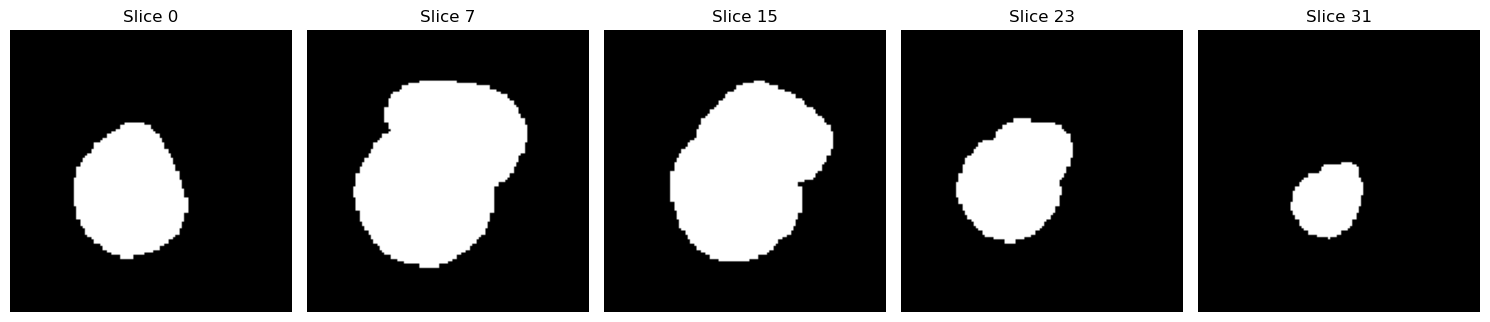

Predict


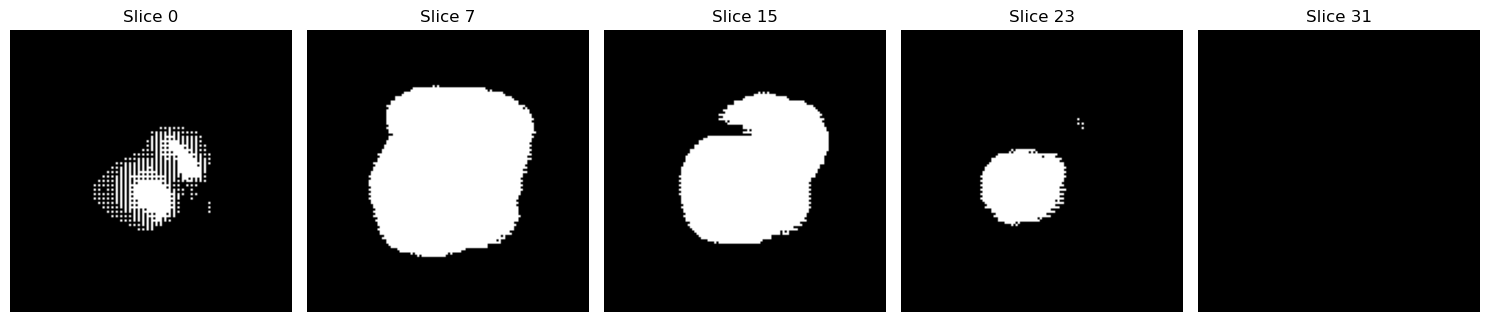

Original, Mask type: 2


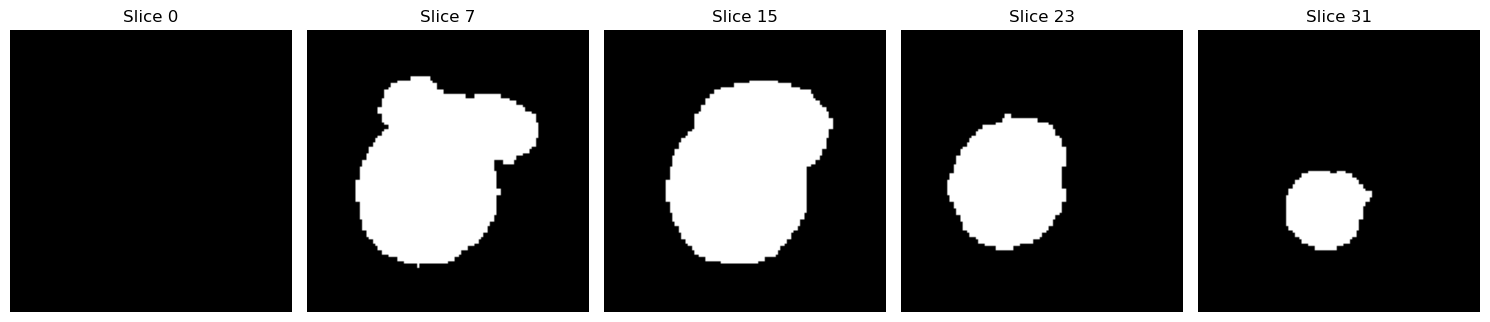

Predict


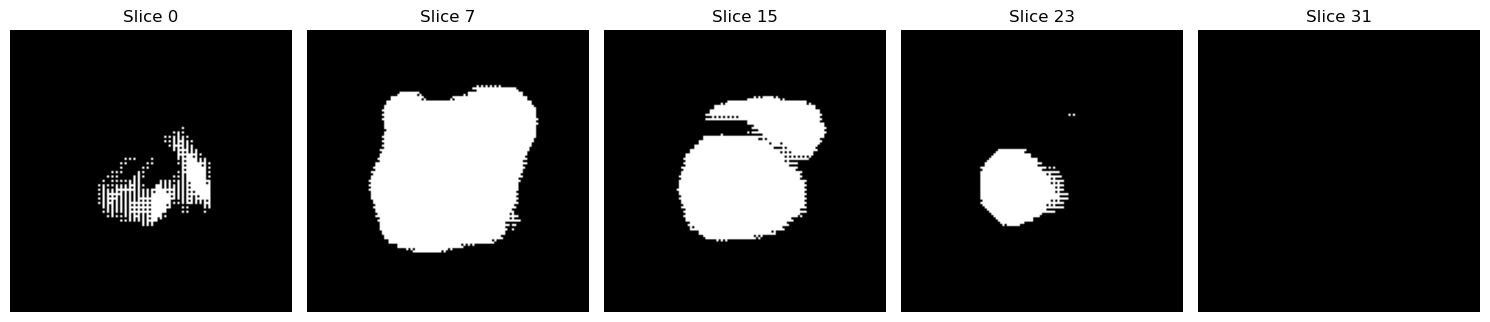

Original, Mask type: 3


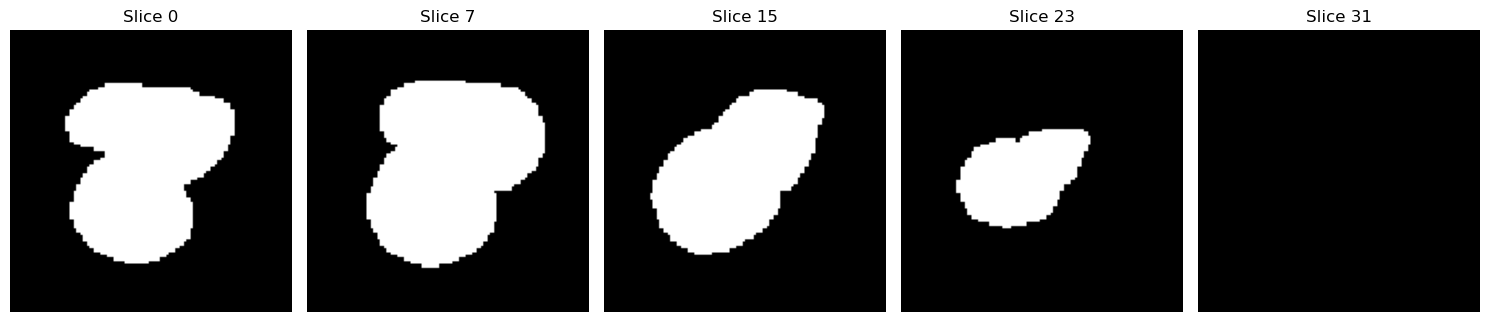

Predict


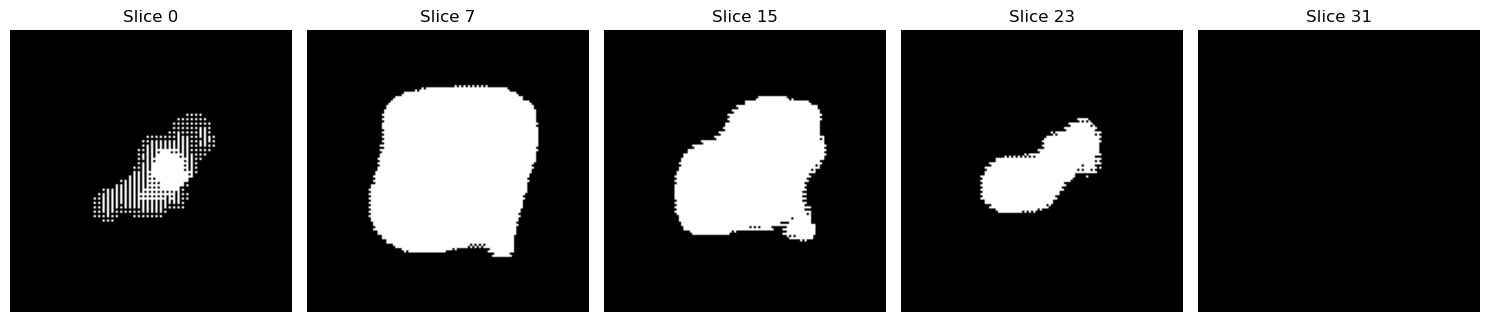

Validation Loss: 0.028777963098357704
0.033637028406648076


In [88]:

def calc_iou(tensor1,tensor2):
    tensor1=(tensor1>= 0.4).int()[:,1,:,:,:]
    tensor2=tensor2.int()
    intersection = torch.sum((tensor1==1)&(tensor2==1))
    union = torch.sum(tensor1 == 1)+torch.sum(tensor2 == 1)
    jaccard_index = intersection / union if union != 0 else 0

    return jaccard_index.item()

iou=0
val_loss = 0.0
data=[]
i=0
for n in range(0,3):
    for images, masks in test_dataloader:
        #plot_data(images,n)
        images=images.to(device)
        masks=masks.to(device)        
        outputs = model(images)
        loss = loss_function(outputs, masks)
        print('Original, Mask type:', n+1)
        plot_mask(masks.detach().cpu(),n)
        print('Predict')
        outputs=(outputs>=0.4).int()
        plot_data(outputs.detach().cpu(),n)
        data.append(outputs.detach().cpu().numpy())
        val_loss += loss.item()
        iou+=(calc_iou(outputs,masks))
        i=i+1
        if i>0:
            break
        
print(f"Validation Loss: {val_loss/len(test_dataloader)}")
print(iou/len(test_dataloader))

# layer test

In [ ]:
i=0
for images, masks in test_dataloader:
    #plot_data(images,n)
    images=images.to(device)
    masks=masks.to(device)
    outputs = model(images)
    loss = loss_function(outputs, masks)
    print(loss)
    loss = loss_function(torch.floor(outputs), torch.floor(masks))
    print(loss)
    
    #print(outputs)
    i=i+1
    if i>0:
        break

In [ ]:
import torch
tens=torch.randint(0,2,(3,2,128,128,32))
print(tens.shape)
tensor1=tens[:,1,:,:,:]
print(tensor1.shape)
tensor2=torch.randint(0,2,3,(3,128,128,32))


In [ ]:
tensor1=(outputs>= 0.4).int()[:,0,:,:,:]
tensor2=masks
intersection = torch.sum((tensor1 == 1) & (tensor2 == 1))
union = torch.sum((tensor1 == 1) | (tensor2 == 1))
jaccard_index = intersection / union if union != 0 else 0

jaccard_index.item()

In [ ]:
array1[array1!=0].size

In [ ]:
np.sum((array1 != 1) & (array2 != 1))

In [47]:
binary_tensor = (outputs>= 0.4).int()  # .int() will make values 0 or 1 as integers

img_data=binary_tensor.cpu().detach().numpy()
img_data.shape

(3, 2, 128, 128, 32)

In [48]:
ms=masks.cpu().detach().numpy()
print(ms.shape)


(3, 128, 128, 32)


In [49]:
bw=img_data
bw=bw.astype(int)
calc_iou(outputs,masks)

0.16112302243709564

In [50]:
def calc_iou_np(array1,array2):
    intersection = np.sum((array1 == 0) & (array2 == 0))
    union = np.sum((array1 == 0) | (array2 == 0))
    jaccard_index_np = intersection / union if union != 0 else 0

    return intersection

1177
3642
998


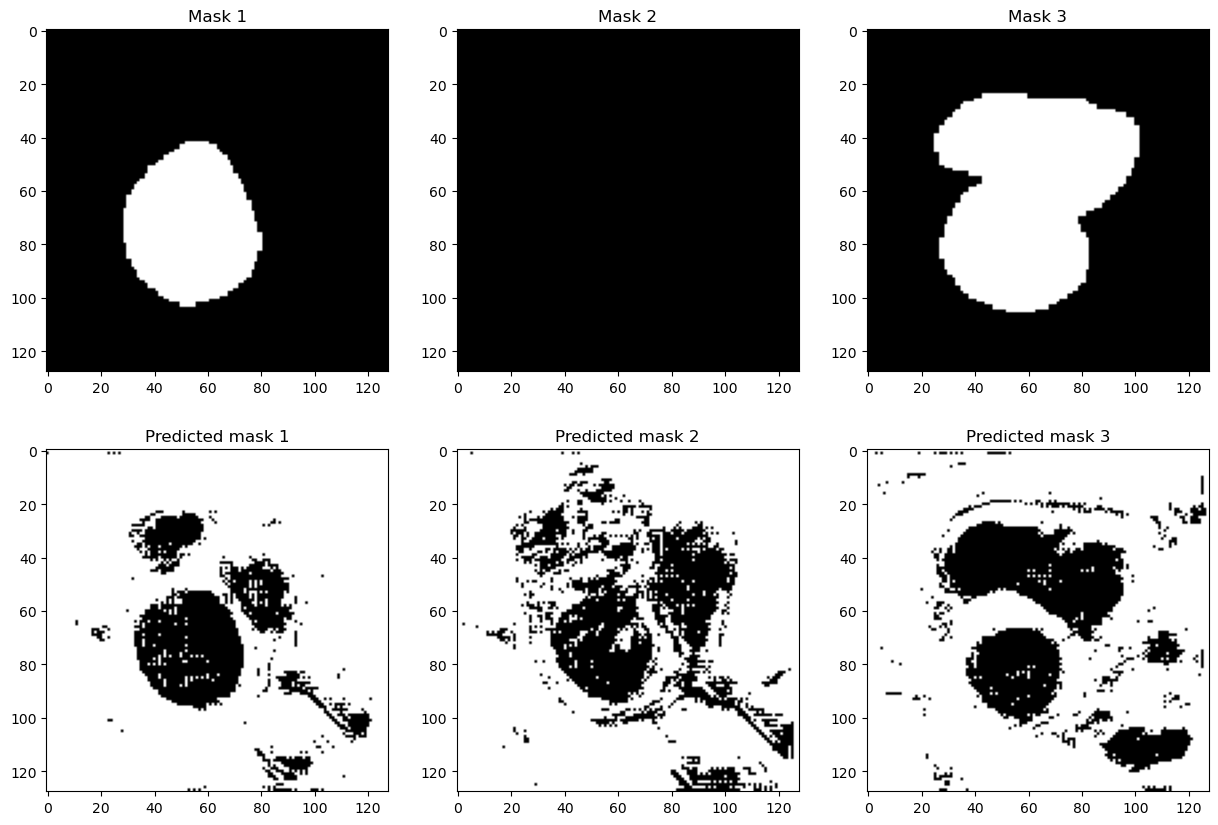

In [51]:
fig = plt.figure(figsize=(15,10))

plt.subplot(2,3, 1)
plt.imshow(ms[0,:, :, 1], cmap='gray')
plt.title('Mask 1')

plt.subplot(2,3, 2)
plt.imshow(ms[1,:, :, 1], cmap='gray')
plt.title('Mask 2')


plt.subplot(2,3, 3)
plt.imshow(ms[2,:, :, 1], cmap='gray')
plt.title('Mask 3')

plt.subplot(2,3, 4)
plt.imshow(bw[0,0,:, :, 1], cmap='gray')
iou=calc_iou_np(bw[0,0,:, :, 1],ms[0,:, :, 1])
print(iou)

plt.title('Predicted mask 1')


plt.subplot(2,3, 5)
plt.imshow(bw[1,0,:, :, 1], cmap='gray')
iou=calc_iou_np(bw[1,0,:, :, 1],ms[1,:, :, 1])
print(iou)

plt.title('Predicted mask 2')

plt.subplot(2,3, 6)
plt.imshow(bw[2,0,:, :, 1], cmap='gray')
iou=calc_iou_np(bw[2,0,:, :, 1],ms[2,:, :, 1])
print(iou)

plt.title('Predicted mask 3')

plt.show()

919
1294
1016


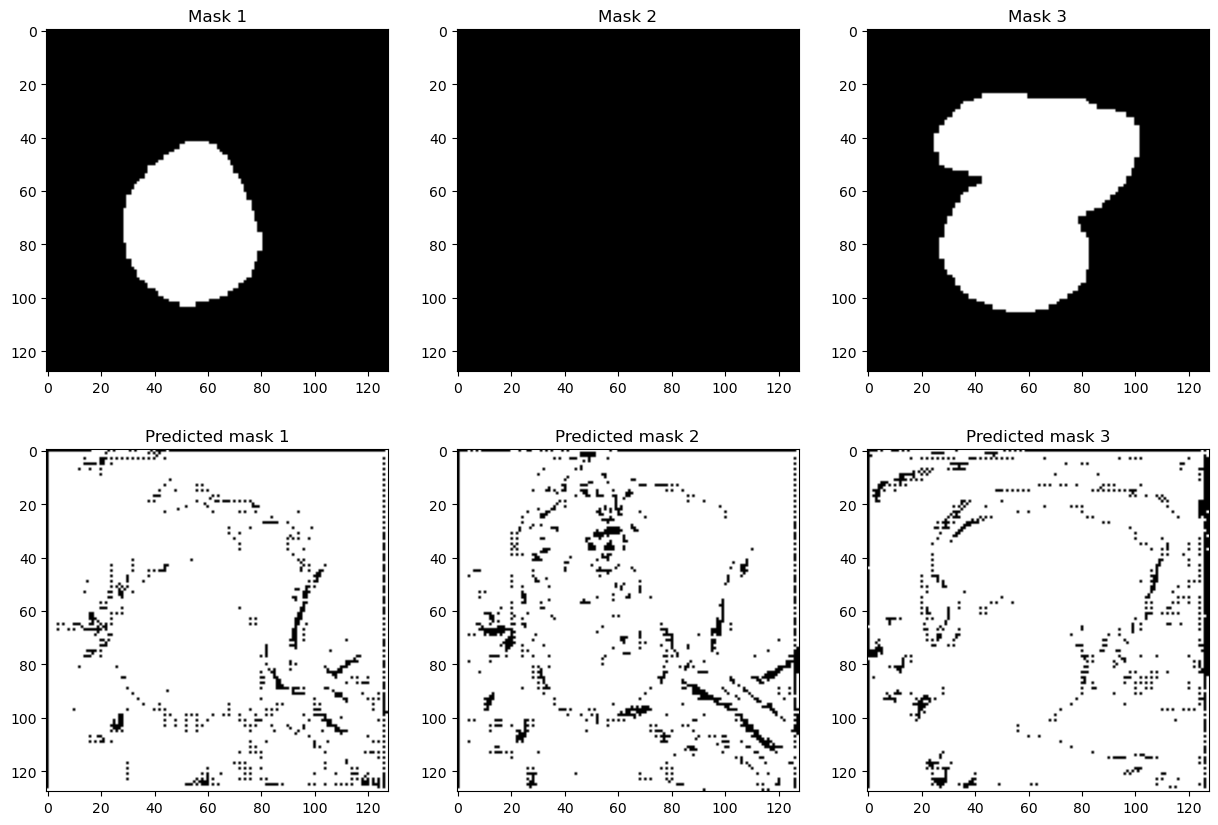

In [52]:
fig = plt.figure(figsize=(15,10))

plt.subplot(2,3, 1)
plt.imshow(ms[0,:, :, 1], cmap='gray')
plt.title('Mask 1')

plt.subplot(2,3, 2)
plt.imshow(ms[1,:, :, 1], cmap='gray')
plt.title('Mask 2')


plt.subplot(2,3, 3)
plt.imshow(ms[2,:, :, 1], cmap='gray')
plt.title('Mask 3')

plt.subplot(2,3, 4)
plt.imshow(bw[0,1,:, :, 1], cmap='gray')
iou=calc_iou_np(bw[0,1,:, :, 1],ms[0,:, :, 1])
print(iou)

plt.title('Predicted mask 1')


plt.subplot(2,3, 5)
plt.imshow(bw[1,1,:, :, 1], cmap='gray')
iou=calc_iou_np(bw[1,1,:, :, 1],ms[1,:, :, 1])
print(iou)

plt.title('Predicted mask 2')

plt.subplot(2,3, 6)
plt.imshow(bw[2,1,:, :, 1], cmap='gray')
iou=calc_iou_np(bw[2,1,:, :, 1],ms[2,:, :, 1])
print(iou)

plt.title('Predicted mask 3')

plt.show()

In [ ]:
def calc_iou_np(array1,array2):
    intersection = np.sum((array1 ==1) & (array2==1))
    print(intersection)
    union = np.sum((array1 == 1)|(array2 == 1))
    print(union)
    jaccard_index_np = intersection / union if union != 0 else 0

    return jaccard_index_np

In [ ]:
asd=np.array([0,3,1,0])
asdd=np.array([0,2,3,0])

In [ ]:
calc_iou_np(asd,asdd)

In [ ]:
bw[2,0,:, :, 1].sum()

In [ ]:
calc_iou_np(bw[1,1,:, :, 1],ms[1,:, :, 1])


In [ ]:
bw[1,1,:, :, 1]

In [ ]:
ms[1,:, :, 1]